## 1. Load in dataset and preprocess it

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
df = pd.read_csv('/Users/yingliang/Desktop/FishTetherProject/FishTetherExperiment/ProcessedData/processed_AnalysisData.csv')

frequency_columns = [col for col in df.columns if col.startswith('F')]
frequency_columns = frequency_columns[3:]

other_columns = ['fishNum', 'species', 'Ping_time', 'dateSample']
frequency_columns.extend(other_columns)

df = df[frequency_columns]
df["pingDateTime"] = pd.to_datetime(df["dateSample"] + " " + df["Ping_time"], errors="coerce")
print(df.head())

         F45      F45.5        F46      F46.5        F47      F47.5  \
0 -48.850989 -47.481644 -45.900477 -44.184644 -42.970845 -41.691276   
1 -47.374837 -47.585660 -47.124362 -45.489171 -43.606820 -41.616682   
2 -47.870826 -49.341342 -49.339863 -47.152783 -44.901575 -42.735101   
3 -44.326289 -45.714510 -47.617086 -48.788610 -48.555806 -46.698281   
4 -41.437463 -42.339934 -43.594854 -44.653928 -45.868339 -46.605502   

         F48      F48.5        F49      F49.5  ...       F258     F258.5  \
0 -40.599349 -39.570164 -38.581552 -37.671468  ... -34.438977 -34.276976   
1 -40.115114 -38.952216 -37.989185 -37.155027  ... -32.662676 -32.770819   
2 -40.998254 -39.533235 -38.270208 -37.192617  ... -35.578946 -35.945827   
3 -44.686905 -42.949347 -41.513695 -40.306633  ... -26.414957 -25.998080   
4 -46.938155 -46.679795 -46.015012 -45.137440  ... -32.225689 -33.095295   

        F259     F259.5       F260  fishNum    species       Ping_time  \
0 -33.769410 -32.877393 -31.754954    LT00

/var/folders/r_/ypjqpbh136gdzxvkn9cvg1wh0000gn/T/ipykernel_41333/4188263284.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/yingliang/Desktop/FishTetherProject/FishTetherExperiment/ProcessedData/processed_AnalysisData.csv')


In [3]:
# Remove Lake White Fish data since there are not many samples and data missing for LWF001-LWF003
df = df.loc[df['species'] != 'lakeWhitefish']

## 2. Build classic machine learning models

#### 2.1 Handle Missing Data

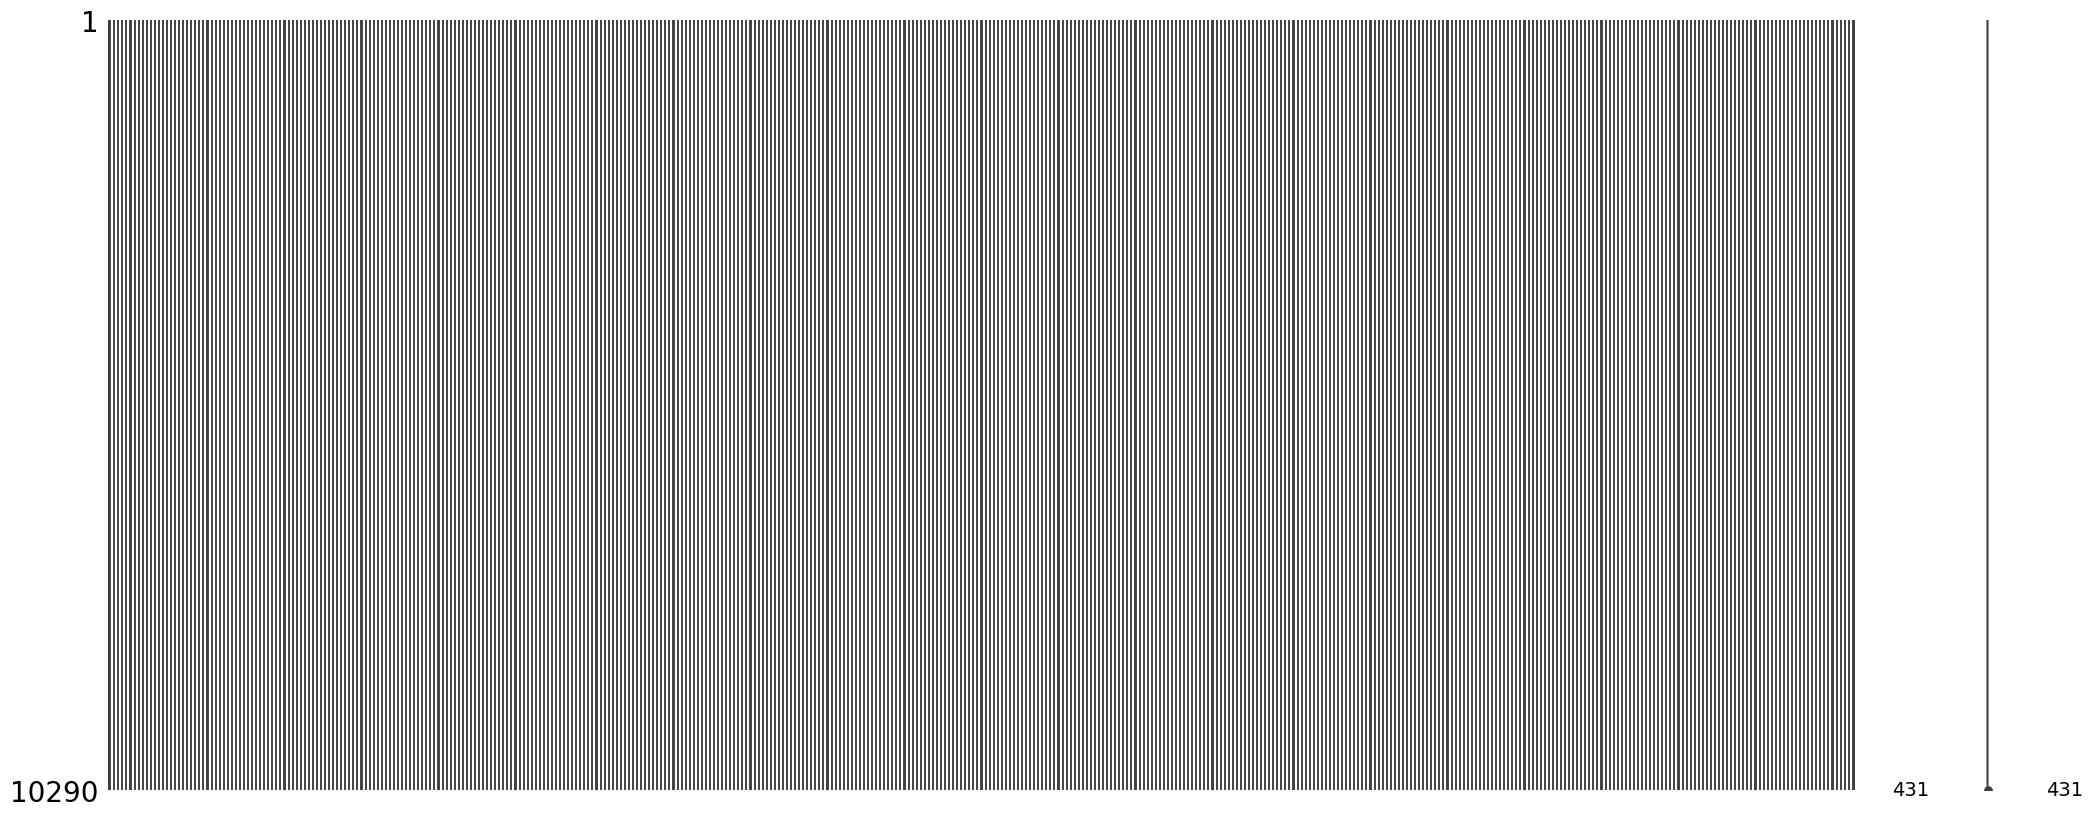

In [4]:
# Extract frequency columns
freq_columns = [col for col in df.columns if col.startswith('F')]

# Function to impute missing values by species
def impute_by_species(df, freq_columns, method='mean'):
    df_imputed = df.copy()
    
    for col in freq_columns:
        # Compute the mean/median of the column for each species
        if method == 'mean':
            impute_values = df.groupby('species')[col].transform(lambda x: x.fillna(x.mean()))
        elif method == 'median':
            impute_values = df.groupby('species')[col].transform(lambda x: x.fillna(x.median()))
        else:
            raise ValueError("Method must be 'mean' or 'median'")
        
        # Assign imputed values
        df_imputed[col] = impute_values

    return df_imputed

# Apply the function
df = impute_by_species(df, freq_columns, method='mean')

# Check if missing values remain
import missingno as msno
msno.matrix(df)
plt.show()

#### 2.2 Time Feature Engineering: Time elapsed since the first ping

In [5]:
df['pingDateTime'] = pd.to_datetime(df['pingDateTime'])
# Calculate time elapsed since the first ping for each fish (in seconds)
# Capture how the fish’s response evolves during the experiment
df['time_elapsed'] = df.groupby('fishNum')['pingDateTime'].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)
features = freq_columns + ['time_elapsed']

/var/folders/r_/ypjqpbh136gdzxvkn9cvg1wh0000gn/T/ipykernel_41333/269528243.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['time_elapsed'] = df.groupby('fishNum')['pingDateTime'].transform(


#### 2.3 Train-Validation-Test Split by Fish

In [6]:
# Split unique fishNum into train/val/test
fish_ids = df['fishNum'].unique()
train_fish, test_fish = train_test_split(fish_ids, test_size=0.2, stratify=df.groupby('fishNum')['species'].first(), random_state=42)
train_fish, val_fish = train_test_split(train_fish, test_size=0.25, stratify=df[df['fishNum'].isin(train_fish)].groupby('fishNum')['species'].first(), random_state=42)

# Filter data
train_df = df[df['fishNum'].isin(train_fish)]
val_df = df[df['fishNum'].isin(val_fish)]
test_df = df[df['fishNum'].isin(test_fish)]

# Features and target
X_train, y_train = train_df[features], train_df['species']
X_val, y_val = val_df[features], val_df['species']
X_test, y_test = test_df[features], test_df['species']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

#### 2.4 Handle Class Imbalance: Class Weighting

In [7]:
# Compute class weights
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train_enc), 
    y=y_train_enc
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

#### 2.5 Train Models

##### 2.5.1 Logistic Regression 

In [8]:
# ======================
# Logistic Regression
# ======================

# Train model
lr = LogisticRegression(
    class_weight='balanced',  
    solver='liblinear',       # Use a solver that supports class weights
    random_state=42
)
lr.fit(X_train, y_train_enc)

# Validation evaluation
lr_val_pred = lr.predict(X_val)
lr_val_proba = lr.predict_proba(X_val)[:,1]

print("\n=== Logistic Regression Validation ===")
print(classification_report(y_val_enc, lr_val_pred))
print(f"ROC-AUC: {roc_auc_score(y_val_enc, lr_val_proba):.4f}")


=== Logistic Regression Validation ===
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1256
           1       0.26      0.30      0.28       390

    accuracy                           0.63      1646
   macro avg       0.52      0.52      0.51      1646
weighted avg       0.65      0.63      0.64      1646

ROC-AUC: 0.5171


##### 2.5.2 Random Forest

In [9]:
# ======================
# Random Forest
# ======================

# Pipeline
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(class_weight=class_weight_dict,
                                  random_state=42))
])

# Hyperparameter grid
rf_params = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

# Tuning
rf_grid = GridSearchCV(rf_pipe, rf_params,
                      cv=StratifiedKFold(3),
                      scoring='roc_auc',
                      n_jobs=-1,
                      verbose=1)
rf_grid.fit(X_train, y_train_enc)

# Best model
best_rf = rf_grid.best_estimator_

# Validation evaluation
rf_val_pred = best_rf.predict(X_val)
rf_val_proba = best_rf.predict_proba(X_val)[:,1]

print("\n=== Random Forest Validation ===")
print(f"Best Params: {rf_grid.best_params_}")
print(classification_report(y_val, le.inverse_transform(rf_val_pred)))
print(f"ROC-AUC: {roc_auc_score(y_val_enc, rf_val_proba):.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== Random Forest Validation ===
Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
                precision    recall  f1-score   support

     lakeTrout       0.78      0.98      0.87      1256
smallmouthBass       0.69      0.11      0.19       390

      accuracy                           0.78      1646
     macro avg       0.74      0.55      0.53      1646
  weighted avg       0.76      0.78      0.71      1646

ROC-AUC: 0.7282


##### 2.5.3 XGBoost

In [10]:
# ======================
# XGBoost
# ======================
scale_pos_weight = (y_train_enc == 0).sum() / (y_train_enc == 1).sum() 

# Pipeline
xgb_pipe = Pipeline([
    ('clf', XGBClassifier(scale_pos_weight=scale_pos_weight,
                         eval_metric='logloss',
                          enable_categorical=False,
                         random_state=42))
])

# Hyperparameter grid
xgb_params = {
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0]
}

# Tuning
xgb_grid = GridSearchCV(xgb_pipe, xgb_params,
                       cv=StratifiedKFold(3),
                       scoring='roc_auc',
                       n_jobs=-1,
                       verbose=1)
xgb_grid.fit(X_train, y_train_enc)

# Best model
best_xgb = xgb_grid.best_estimator_

# Validation evaluation
xgb_val_pred = best_xgb.predict(X_val)
xgb_val_proba = best_xgb.predict_proba(X_val)[:,1]

print("\n=== XGBoost Validation ===")
print(f"Best Params: {xgb_grid.best_params_}")
print(classification_report(y_val, le.inverse_transform(xgb_val_pred)))
print(f"ROC-AUC: {roc_auc_score(y_val_enc, xgb_val_proba):.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

=== XGBoost Validation ===
Best Params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__subsample': 1.0}
                precision    recall  f1-score   support

     lakeTrout       0.82      0.67      0.74      1256
smallmouthBass       0.33      0.52      0.40       390

      accuracy                           0.64      1646
     macro avg       0.57      0.60      0.57      1646
  weighted avg       0.70      0.64      0.66      1646

ROC-AUC: 0.6774


## 3. Build deep learning models

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

### 3.1 Create sequences

In [12]:
# First, ensure data is properly sorted
df = df.sort_values(['fishNum', 'pingDateTime'])
df.head()

# Define sequence parameters
MAX_SEQUENCE_LENGTH = 17  # based on my EDA
TIME_DELTA_THRESHOLD = pd.Timedelta('500ms')  # 0.5 seconds

In [13]:
def create_sequences(group):
    sequences = []
    current_sequence = []
    prev_time = None
    
    for _, row in group.iterrows():
        if prev_time is None or (row['pingDateTime'] - prev_time) <= TIME_DELTA_THRESHOLD:
            current_sequence.append(row)
        else:
            if len(current_sequence) >= 1:  # Minimum sequence length
                sequences.append(current_sequence)
            current_sequence = [row]
        prev_time = row['pingDateTime']
    
    if len(current_sequence) >= 1:
        sequences.append(current_sequence)
    
    return sequences

sequences = []
labels = []
fish_numbers = []
features = [col for col in df.columns if col.startswith('F')] + ['time_elapsed']

for fish_num, group in df.groupby('fishNum'):
    fish_sequences = create_sequences(group)
    for seq in fish_sequences:
        #print(seq)
        seq_df = pd.DataFrame(seq)
        #print(seq_df)
        sequences.append(seq_df[features].values)
        #print(sequences)
        labels.append(seq_df['species'].iloc[0])  # All pings in sequence same species
        fish_numbers.append(fish_num)

In [14]:
# Pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post', truncating='post')
y = LabelEncoder().fit_transform(labels)

### 3.2 Data Splitting with Sequence Awareness

In [15]:
train_fish = set(train_df['fishNum'].unique())
val_fish = set(val_df['fishNum'].unique())
test_fish = set(test_df['fishNum'].unique())

# Create masks using stored fish_numbers
train_mask = [fish_num in train_fish for fish_num in fish_numbers]
val_mask = [fish_num in val_fish for fish_num in fish_numbers]
test_mask = [fish_num in test_fish for fish_num in fish_numbers]

# Apply masks
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

In [16]:
X_train[1:3]

array([[[-33.789154, -33.65368 , -33.650127, ..., -36.762592,
         -35.392704,   1.769   ],
        [-33.969067, -33.692936, -33.47688 , ..., -37.160095,
         -39.254944,   1.896   ],
        [-33.41668 , -33.09398 , -32.84975 , ..., -39.48631 ,
         -39.79466 ,   2.021   ],
        ...,
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ]],

       [[-35.31325 , -35.368088, -35.431873, ..., -39.704308,
         -39.038986,   3.277   ],
        [-34.916985, -34.363155, -34.011868, ..., -32.94879 ,
         -32.0524  ,   3.403   ],
        [-36.92243 , -36.599297, -36.50434 , ..., -33.53907 ,
         -33.651054,   3.527   ],
        ...,
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0

In [17]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

### 3.3 Build models

#### 3.3.1 GRU Model

In [24]:
def build_model(input_shape):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        GRU(64, return_sequences=True),
        GRU(32),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.AUC(name='roc_auc')]
    )
    return model

gru = build_model((MAX_SEQUENCE_LENGTH, len(features)))
gru.summary()

/Users/yingliang/Desktop/FishTetherProject/lib/python3.9/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 17, 427)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 17, 64)         │        94,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,609 (408.63 KB)

 Trainable params: 104,609 (408.63 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

early_stop = EarlyStopping(monitor='val_roc_auc', patience=5, mode='max', restore_best_weights=True)

history = gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5117 - loss: 0.7209 - roc_auc: 0.4963 - val_accuracy: 0.6975 - val_loss: 0.6414 - val_roc_auc: 0.5110
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6752 - loss: 0.7145 - roc_auc: 0.5073 - val_accuracy: 0.5154 - val_loss: 0.6756 - val_roc_auc: 0.5660
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6914 - loss: 0.6920 - roc_auc: 0.5769 - val_accuracy: 0.4228 - val_loss: 0.7050 - val_roc_auc: 0.5512
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3441 - loss: 0.6857 - roc_auc: 0.6284 - val_accuracy: 0.5031 - val_loss: 0.6807 - val_roc_auc: 0.5708
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6141 - loss: 0.6599 - roc_auc: 0.6902 - val_accuracy: 0.6975 - val_loss: 0.6044 - val_roc_auc: 0.6061
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6123 - loss: 0.6838 - roc_auc: 0.6512 - val_accuracy: 0.4383 - val_loss: 0.7341 - val_roc_auc: 0.598